In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

## Step 1 - Read Images

In [2]:
# reading image paths with glob
vehicle_image_arr = glob.glob('/media/rd_square/Important/Image_processing/car_data_with_neg/vehicles/*/*.png')

# read images and append to list
vehicle_images_original = []
for imagePath in vehicle_image_arr:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)
    
print('Reading of Vehicle Images Done')

non_vehicle_image_arr = glob.glob('/media/rd_square/Important/Image_processing/car_data_with_neg/non-vehicles/*/*.png')

non_vehicle_images_original = []
for imagePath in non_vehicle_image_arr:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)
    
print("Reading of Non Vehicle Images Done")

print("No of Vehicle Images loaded - "+str(len(vehicle_images_original)))
print("No of Non-Vehicle Images Loaded - "+str(len(non_vehicle_images_original)))

Reading of Vehicle Images Done
Reading of Non Vehicle Images Done
No of Vehicle Images loaded - 575
No of Non-Vehicle Images Loaded - 100


Shape of Vehicle Image (64, 64, 3)
Shape of Non Vehicle Image (64, 64, 3)


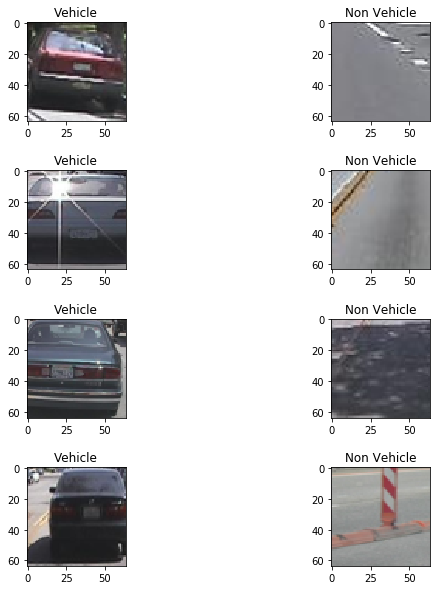

In [3]:
# Visualizing the Vehicle and Non Vehicle Images

f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0,len(non_vehicle_images_original)-1)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")
print("Shape of Vehicle Image "+str(vehicle_images_original[vehicle].shape))
print("Shape of Non Vehicle Image "+str(non_vehicle_images_original[non_vehicle].shape))

## Step 2 - Extract Features

### Step 2.1 HOG (Histogram of Oriented Gradients)

In [4]:
# General method to extract the HOG of the image

def GetFeaturesFromHOG(image, orient, cellsPerBlock,pixelsPerCell, visualise=False, feature_vector_flag=True):
    hog_features, hog_image = hog(image, orientations=orient,
                                 pixels_per_cell=(pixelsPerCell, pixelsPerCell),
                                 cells_per_block=(cellsPerBlock, cellsPerBlock),
                                 visualise=True, feature_vector=feature_vector_flag)
    return hog_features, hog_image

/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


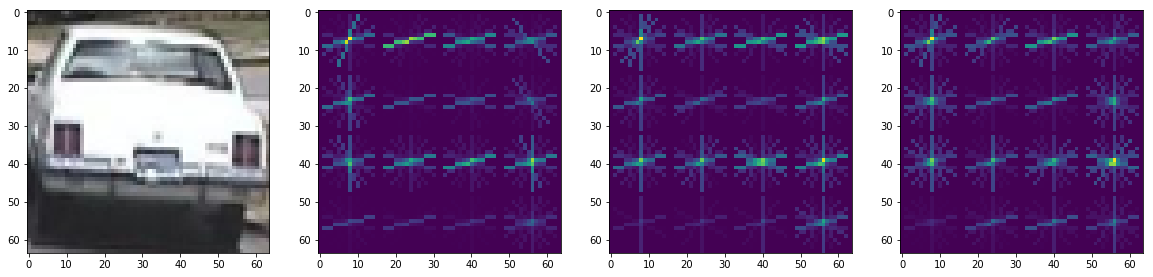

In [5]:
# testing HOG on test images

image=vehicle_images_original[1]
image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0 = image[:,:,0]
image_channel_1 = image[:,:,1]
image_channel_2  = image[:,:,2]

feature_0, hog_img_0 = GetFeaturesFromHOG(image_channel_0,9,2,16,visualise=True, feature_vector_flag=True)
feature_1, hog_img_1 = GetFeaturesFromHOG(image_channel_1,9,2,16,visualise=True, feature_vector_flag=True)
feature_2, hog_img_2 = GetFeaturesFromHOG(image_channel_2,9,2,16,visualise=True, feature_vector_flag=True)

f, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(vehicle_images_original[1])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)

print("Feature Vector Length Returned is ", len(feature_0))
print("No of features that can be extracted from image ", len(hog_img_0.ravel()))

### Step 3 - Generate Features Data

In [6]:
# Method to extract the features based on the choices as available in step 2

def ExtractFeatures(images, orientation, cellsPerBlock, pixelsPerCell, convertColorspace=False):
    featureList = []
    imageList = []
    for image in images:
        if(convertColorspace==True):
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1, img = GetFeaturesFromHOG(image[:,:,0],orientation,cellsPerBlock, pixelsPerCell, False, True)
        local_features_2, img = GetFeaturesFromHOG(image[:,:,1],orientation,cellsPerBlock, pixelsPerCell, False, True)
        local_features_3, img = GetFeaturesFromHOG(image[:,:,2],orientation,cellsPerBlock, pixelsPerCell, False, True)
        
        x = np.hstack((local_features_1, local_features_2, local_features_3))
        featureList.append(x)
    return featureList

In [7]:
%%time

orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
vehicleFeatures = ExtractFeatures(vehicle_images_original,orientations, cellsPerBlock, pixelsPerBlock,convertColorSpace)
nonVehicleFeatures = ExtractFeatures(non_vehicle_images_original,orientations, cellsPerBlock, pixelsPerBlock,convertColorSpace)

/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 48.3 s, sys: 176 ms, total: 48.5 s
Wall time: 48.6 s


In [8]:
featuresList = np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)
labelList = np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)

Shape of features list is  (675, 972)
Shape of label list is  (675,)


### Step 4 - Data Preprocessing

In [9]:
# train test split of data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)

In [10]:
# normalization and scaling

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [11]:
%%time

# Train a Linear SVM classifer
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, Y_train)
print()


CPU times: user 160 ms, sys: 44 ms, total: 204 ms
Wall time: 207 ms


In [12]:
print("Accuracy of SVC is ", classifier.score(X_test, Y_test))

Accuracy of SVC is  1.0


### Sliding Window

In [26]:
# function to draw sliding windows

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        color = (r,g,b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [14]:
# function to find the windows on which we are going to run the classifier

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None,None],
                xy_window=(64,64), xy_overlap=(0.9,0.9)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    window_list = []
    image_width_x = x_start_stop[1] - x_start_stop[0]
    image_width_y = y_start_stop[1] - y_start_stop[0]
    
    windows_x = np.int(1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int(1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size=  xy_window
    for i in range(0, windows_y):
        y_start = y_start_stop[0] + np.int(i * modified_window_size[1] * xy_overlap[1])
        for j in range(0, windows_x):
            x_start = x_start_stop[0] + np.int(j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int(x_start+modified_window_size[0])
            y1 = np.int(y_start + modified_window_size[1])
            window_list.append(((x_start,y_start), (x1,y1)))
    return window_list

In [15]:
# function that returns the refined windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car

def DrawCars(image, windows, convertColorspace= False):
    refinedWindows = []
    for window in windows:
        
        start = window[0]
        end = window[1]
        clippedImage = image[start[1]:end[1], start[0]:end[0]]
        
        if (clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1] != 0):
            clippedImage = cv2.resize(clippedImage, (64,64))
            
            f1 = ExtractFeatures([clippedImage], 9,2,16,convertColorspace)
            
            predictedOutput = classifier.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        return refinedWindows

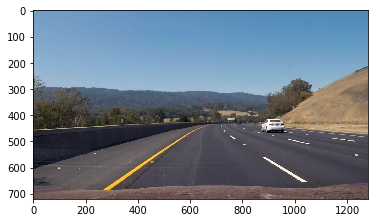

In [16]:
# testing out functions of slide_window and draw window. Defining here dummy windows

image = mpimg.imread('test3.jpg')

plt.imshow(image)

In [17]:
windows1  = slide_window(image, x_start_stop=[0,1280], y_start_stop=[200,700],
                        xy_window=(64,64), xy_overlap=(0.15,0.15))
windows2 = slide_window(image, x_start_stop=[0,1280], y_start_stop=[200,700],
                       xy_window=(96,96), xy_overlap=(0.3,0.3))
windows3 = slide_window(image, x_start_stop=[0,1280], y_start_stop=[200,700],
                       xy_window=(128,128), xy_overlap=(0.5,0.5))
windows4 = slide_window(image, x_start_stop=[0,1280], y_start_stop=[200,700],
                       xy_window=(80,80), xy_overlap=(0.2, 0.2))

windows = windows1 + windows2 +windows3+windows4
print("Total No of windows are ", len(windows))


Total No of windows are  8638


/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


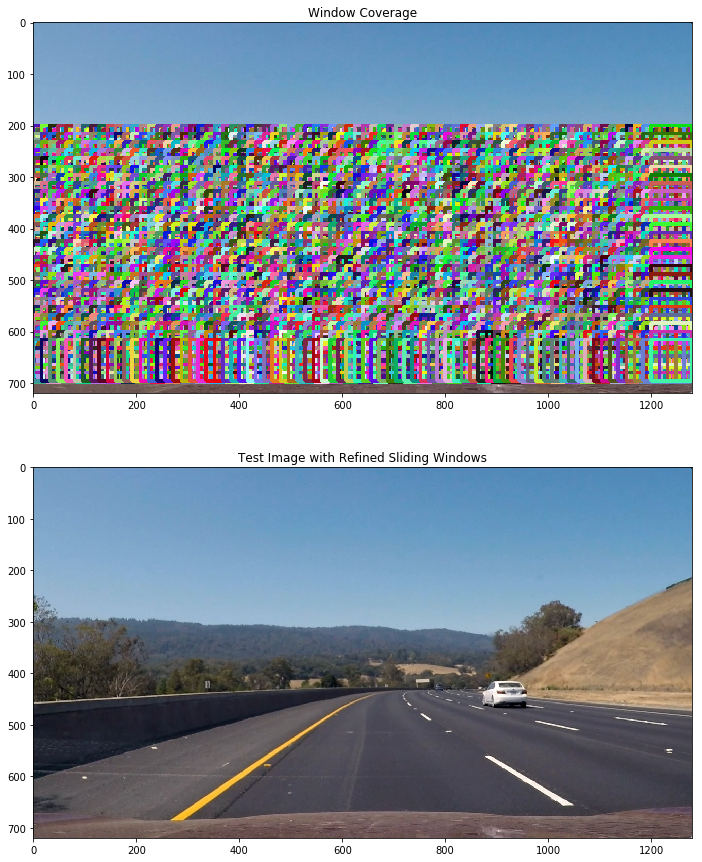

In [18]:
refinedWindows = DrawCars(image, windows, True)

f,axes = plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows)

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows)

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

In [19]:
anotherImage = mpimg.imread('test3.jpg')

In [33]:
# Search for car in image

def findCar(image, start_x = 0, start_y = 0, window_size=(64,64), convertColorspace=True):
    # list of all cars window searched
    carWindowList = []
    for row in range(start_x, start_x+1):
        for col in range(start_y, image.shape[1]-window_size[1]):
            print(row, col)
            clippedImage = image[row:row+window_size[0], col:col+window_size[0]]
            
            clippedImage = cv2.resize(clippedImage, (64, 64))
            
            f1= ExtractFeatures([clippedImage], 9, 2, 16, convertColorspace)
            
            predictedOutput = classifier.predict([f1[0]])
            if (predictedOutput==1):
                carWindowList.append([[col,row],[col+window_size[0], row+window_size[0]]])
    return carWindowList

In [34]:
cars = findCar(anotherImage, start_x=400, start_y=400)

400 400
400 401
400 402


/home/rd_square/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


400 403
400 404
400 405
400 406
400 407
400 408
400 409
400 410
400 411
400 412
400 413
400 414
400 415
400 416
400 417
400 418
400 419
400 420
400 421
400 422
400 423
400 424
400 425
400 426
400 427
400 428
400 429
400 430
400 431
400 432
400 433
400 434
400 435
400 436
400 437
400 438
400 439
400 440
400 441
400 442
400 443
400 444
400 445
400 446
400 447
400 448
400 449
400 450
400 451
400 452
400 453
400 454
400 455
400 456
400 457
400 458
400 459
400 460
400 461
400 462
400 463
400 464
400 465
400 466
400 467
400 468
400 469
400 470
400 471
400 472
400 473
400 474
400 475
400 476
400 477
400 478
400 479
400 480
400 481
400 482
400 483
400 484
400 485
400 486
400 487
400 488
400 489
400 490
400 491
400 492
400 493
400 494
400 495
400 496
400 497
400 498
400 499
400 500
400 501
400 502
400 503
400 504
400 505
400 506
400 507
400 508
400 509
400 510
400 511
400 512
400 513
400 514
400 515
400 516
400 517
400 518
400 519
400 520
400 521
400 522
400 523
400 524
400 525
400 526
400 527


In [35]:
len(cars)

114

In [36]:
temp = draw_boxes(anotherImage, cars)

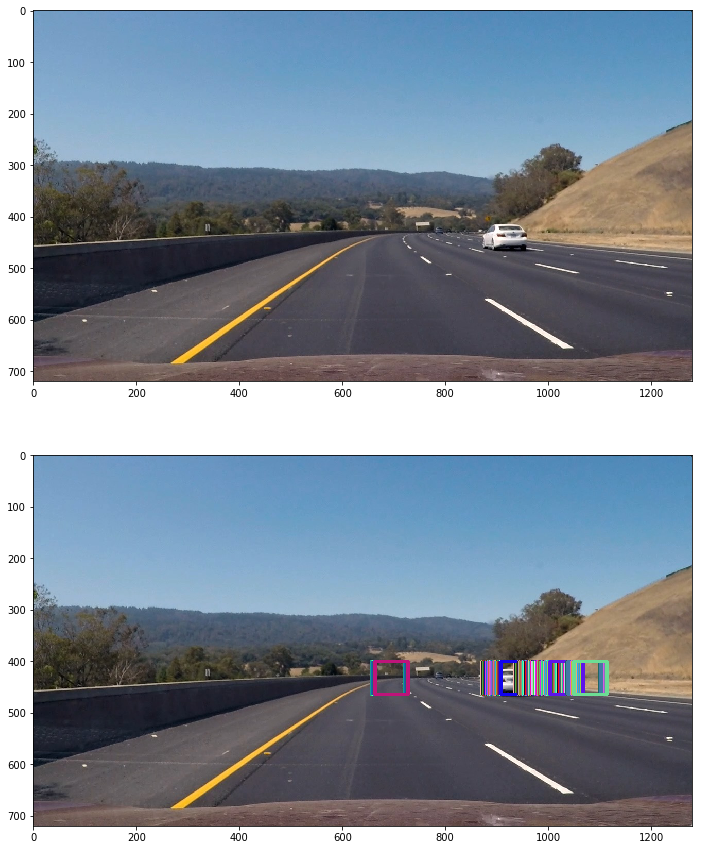

In [37]:
f, axes = plt.subplots(2,1, figsize=(30,15))

axes[0].imshow(anotherImage)
axes[1].imshow(temp)

In [38]:
# function to increase the pixel by on einside each box

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1,y1), (x2,y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

In [39]:
# applying a threshold value to the image to filter out low pixel cells

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

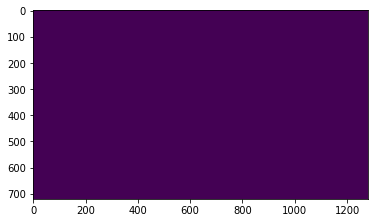

In [72]:
# testing our heat function

heat =np.zeros_like(image[:,:,0]).astype(np.float)
heat
plt.imshow(heat)

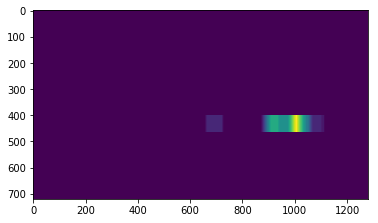

In [73]:
heat1 = add_heat(heat, cars)
plt.imshow(heat1)

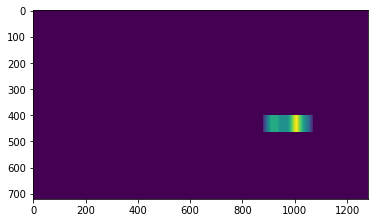

In [74]:
# Visualize the heatmap when displaying
heat2 = apply_threshold(heat1,7)
plt.imshow(heat2)

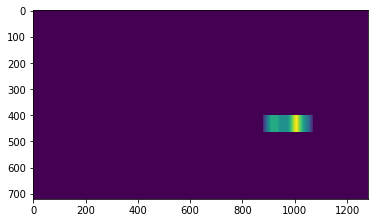

In [75]:
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap)

In [76]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    return img

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 1)
Number of cars found -  1


Text(0.5,1,'Final image after applying heat map')

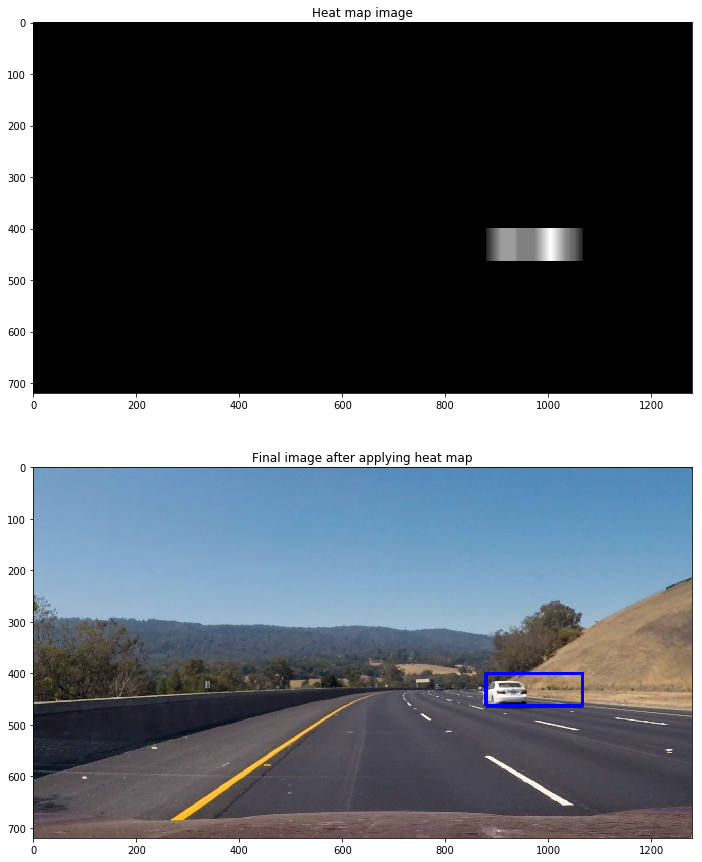

In [77]:
labels = label(heatmap)
print(labels)
print("Number of cars found - ", labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes = plt.subplots(2,1,figsize=(30,15))
axes[0].imshow(heatmap, cmap='gray')
axes[0].set_title("Heat map image")
axes[1].imshow(draw_img)
axes[1].set_title("Final image after applying heat map")

In [2]:
a = int(input('Enter a number: '))
total = 0
for i in range(a):
    b = int(input('Enter another number: '))
    total = total +b
    print(total)
print(total)

Enter a number: 5
Enter another number: 2
2
Enter another number: 5
7
Enter another number: 7
14
Enter another number: 4
18
Enter another number: 5
23
23
